In [1]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
sns.set()

In [2]:
dataset_path = os.path.join("data", "cluster.dat")

## Utility functions

In [3]:
def get_range(data, feature=0):
    return [min(data[:, feature]), max(data[:, feature])]

def plot_data(data, plot_title="Scatter plot"):
    plt.figure(figsize=(12, 8))
    plt.title(plot_title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.scatter(data[:, 0], data[:, 1])
    plt.show()

def plot_data_with_labels(data, clusters_center, labels, plot_title="Scatter plot"):
    plt.figure(figsize=(12, 8))
    plt.title(plot_title)
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')

    c1_points = np.where(labels == 0)
    c2_points = np.where(labels == 1)
    c3_points = np.where(labels == 2)

    plt.scatter(data[c1_points, 0], data[c1_points, 1], color="red")
    plt.scatter(data[c2_points, 0], data[c2_points, 1], color="blue")
    plt.scatter(data[c3_points, 0], data[c3_points, 1], color="green")
    plt.scatter(clusters_center[:, 0], clusters_center[:, 1], marker='x', color='black', s=100)
    plt.show()

## Load and analyze the dataset

Simple analysis of the dataset, observing:
- The number of data in the dataset
- The number of features for each data in the dataset;
- The way the data is distributed

Number of samples in the dataset: 573
Number of features per sample: 2
Shape of the dataset: (573, 2)
Example of data: [1555.     28.65] <class 'numpy.ndarray'>

Range feature 0: [335.0, 3635.0]
Range feature 1: [1.95, 29.15]
Features data type:  <class 'numpy.float64'>


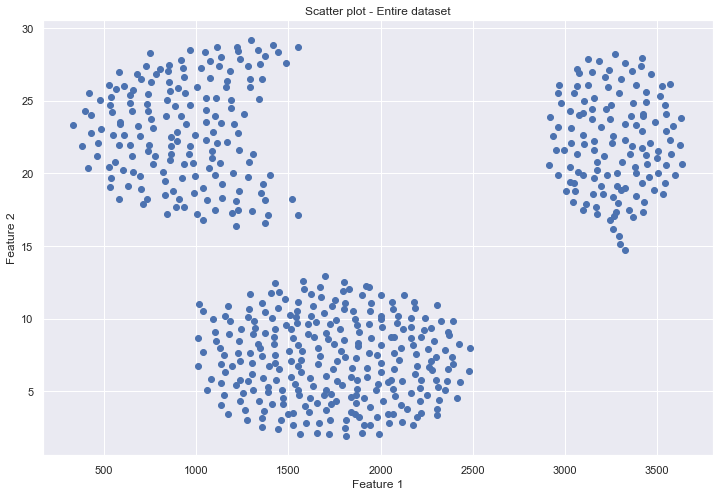

In [4]:
data = np.genfromtxt(dataset_path, delimiter=' ')

range_f0 = get_range(data, feature=0)
range_f1 = get_range(data, feature=1)

print("Number of samples in the dataset:", data.shape[0])
print("Number of features per sample:", data.shape[1])
print("Shape of the dataset:", data.shape)
print("Example of data: {} {}".format(data[0], type(data[0])))

print()
print("Range feature 0: {}".format(range_f0))
print("Range feature 1: {}".format(range_f1))
print("Features data type: ", type(data[0][0]))

plot_data(data, plot_title="Scatter plot - Entire dataset")

## Splitting the dataset and analysis of each set 

Spliting the dataset into training and test set, with respectively 90% and 10% of the data in each set.

* The **training set** will be used to run k-means and define the clusters.
* The **test set** will be used to evaluate the performance of the algorithm.

In addition to the split of data, this cell makes a simple analysis of the set.

Training set
Number of samples: 515
Shape: (515, 2)
Range feature 0: [655.0, 3550.0]
Range feature 1: [2.85, 28.65]

Test set
Number of samples: 58
Shape: (58, 2)
Range feature 0: [655.0, 3550.0]
Range feature 1: [2.85, 28.65]


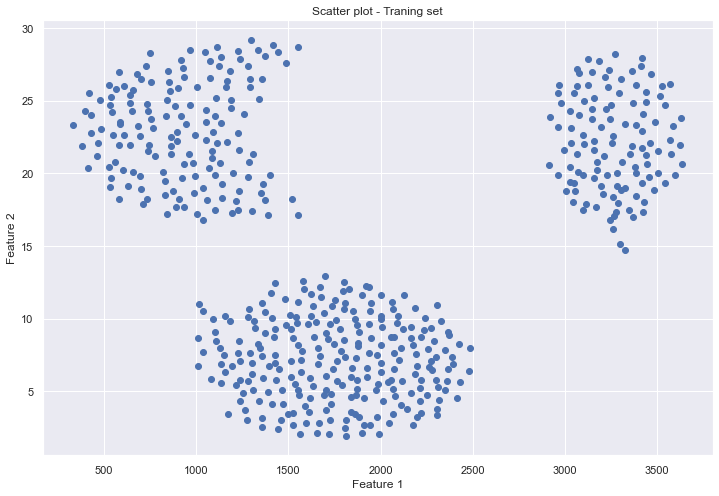

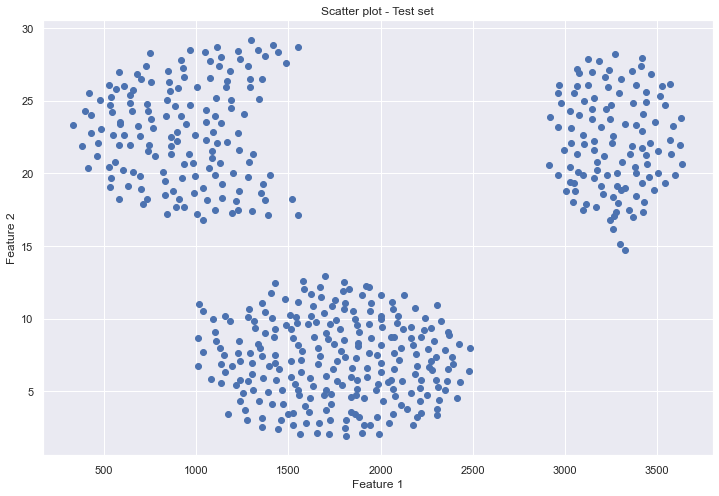

In [5]:
train_data, test_data = train_test_split(data,
                                         test_size=0.10,
                                         random_state=27,
                                         shuffle=True)
print("Training set")
print("Number of samples:", train_data.shape[0])
print("Shape:", train_data.shape)
print("Range feature 0: {}".format(get_range(test_data, feature=0)))
print("Range feature 1: {}".format(get_range(test_data, feature=1)))

print("\nTest set")
print("Number of samples:", test_data.shape[0])
print("Shape:", test_data.shape)
print("Range feature 0: {}".format(get_range(test_data, feature=0)))
print("Range feature 1: {}".format(get_range(test_data, feature=1)))

plot_data(train_data, "Scatter plot - Traning set")
plot_data(train_data, "Scatter plot - Test set")

## Feature scaling - Training set

Applying a min-max scaling (normalization) to the data

In [6]:
for i in range(train_data.shape[1]):
    x_min = min(train_data[:, i])
    x_max = max(train_data[:, i])
    diff = x_max - x_min
    for j in range(train_data.shape[0]):
        train_data[j][i] = (train_data[j][i] - x_min) / diff

range_f0 = get_range(train_data, feature=0)
range_f1 = get_range(train_data, feature=1)

print("Range feature 0 after feature scaling: {}".format(range_f0))
print("Range feature 1 after feature scaling: {}".format(range_f1))
print("Example of data: {} {}".format(train_data[0], type(train_data[0])))

Range feature 0 after feature scaling: [0.0, 1.0]
Range feature 1 after feature scaling: [0.0, 1.0]
Example of data: [0.26666667 0.12683824] <class 'numpy.ndarray'>


## Feature scaling - Test set

In [7]:
for i in range(test_data.shape[1]):
    x_min = min(test_data[:, i])
    x_max = max(test_data[:, i])
    diff = x_max - x_min
    for j in range(test_data.shape[0]):
        test_data[j][i] = (test_data[j][i] - x_min) / diff

range_f0 = get_range(test_data, feature=0)
range_f1 = get_range(test_data, feature=1)

print("Range feature 0 after feature scaling: {}".format(range_f0))
print("Range feature 1 after feature scaling: {}".format(range_f1))
print("Example of data: {} {}".format(test_data[0], type(test_data[0])))

Range feature 0 after feature scaling: [0.0, 1.0]
Range feature 1 after feature scaling: [0.0, 1.0]
Example of data: [0.9343696  0.81589147] <class 'numpy.ndarray'>


## Algorithm implementation (k-means)

In [8]:
class KMeans():
    def __init__(self, n_clusters=3, n_features=2, init="random",
                 max_iterations=300, tolerance=0.0001):
        self.init = init
        self.tolerance = tolerance
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.max_iterations = max_iterations
        
        self.clusters_center = np.zeros((self.n_clusters, self.n_features))

    def init_clusters(self, data, init="random"):        
        if init == "random":
            self.clusters_center = np.random.rand(self.n_clusters, self.n_features)
            for i in range(self.n_features):
                self.clusters_center[:, i] *= np.max(data[:, i])
        elif init == "forgy":
            self.clusters_center = data[np.random.choice(len(data),
                                                         self.n_clusters,
                                                         replace=False)]
        elif init =="kmeans++":
            self.clusters_center = np.ones((self.n_clusters, self.n_features)) * np.Inf
            
            choosen_datapoint_idx = np.random.choice(len(data), 1)[0]
            self.clusters_center[0] = data[choosen_datapoint_idx]
            
            for cluster_id in range(1, self.n_clusters):
                distances = np.ones(data.shape[0]) * np.inf
                for i, datapoint in enumerate(data):
                    for cluster_center in self.clusters_center:
                        distance = self.get_distance(datapoint, cluster_center)
                        if distance < distances[i]:
                            distances[i] = distance

                probabilities = (distances ** 2) /sum(distances ** 2)
                choosen_datapoint_idx = np.random.choice(len(data),
                                                         1, p=probabilities)
                self.clusters_center[cluster_id] = data[choosen_datapoint_idx]

    def get_distance(self, p1, p2):
        return np.sqrt(sum((p1 - p2) ** 2))
    
    def get_distance_point_to_set_points(self, point, set_points):
        distance = 0
        for point_ in set_points:
            distance += self.get_distance(point, point_)
            
        return distance     
    
    def get_diff_pos_cluster(self):
        diff = 0
        
        for cluster, old_cluster in zip(self.clusters_center, self.old_clusters_center):
            diff += self.get_distance(cluster, old_cluster)
        
        return diff

    def assign_datapoints_to_clusters(self, data):
        labels = np.zeros(data.shape[0], dtype=np.int)
        distances = np.ones(data.shape[0]) * np.inf
        
        for idx, datapoint in enumerate(data):
            for cluster_id, cluster_center in enumerate(self.clusters_center):
                distance = self.get_distance(datapoint, cluster_center)
                if distance < distances[idx]:
                    distances[idx] = distance
                    labels[idx] = cluster_id

        return labels, distances

    def update_clusters_center(self, data):
        self.old_clusters_center = self.clusters_center
        self.clusters_center = np.zeros((self.n_clusters, self.n_features))
        counter = np.zeros(self.n_clusters)
        
        for i in range(len(self.labels)):
            label = self.labels[i]
            counter[label] += 1
            for j in range(self.n_features):
                self.clusters_center[label][j] += data[i][j]
        
        for i in range(self.n_clusters):
            if counter[i] > 0:
                self.clusters_center[i] /= counter[i]
            else:
                self.clusters_center[i] = self.old_clusters_center[i]

    def fit(self, data):
        self.labels = np.zeros(data.shape[0], dtype=np.int)
        self.distances = np.zeros(data.shape[0], dtype=np.int)
        self.range_f0 = get_range
        n_iterations = 1
        diff_pos_cluster = np.Inf

        self.init_clusters(data, init=self.init)

        while n_iterations <= self.max_iterations and diff_pos_cluster > self.tolerance:
            self.labels, self.distances = self.assign_datapoints_to_clusters(data)
            self.update_clusters_center(data)
            diff_pos_cluster = self.get_diff_pos_cluster()
            n_iterations += 1
        
        return self.labels, self.clusters_center, n_iterations
    
    def predict(self, data):
        return self.assign_datapoints_to_clusters(data)
    
    def get_sse(self, by_cluster=True):
        # SSE = Sum of Squared error = sum(distances^2)
        sse = np.empty(self.n_clusters)
        for cluster_id in range(len(self.clusters_center)):
            sse[cluster_id] = sum(self.distances[np.where(self.labels == cluster_id)] ** 2)
        
        if by_cluster:
            return sse
        else:
            return sum(sse)
    
    def get_silhouette_coefficient(self, data):
        """ 
            silhouette_datapoint = (a - b)/max(a, b)
            
            where:
              - a: The mean distance between a sample and all other points in the 
              same cluster.
              - b: The mean distance between a sample and all other points in the
              next nearest cluster.
              
            -1 <= silhouette_datapoint <= 1
        """
        silhouette_coeff = np.zeros(data.shape[0])
        
        datapoints_per_cluster = []
        for cluster_id in range(self.n_clusters):
            datapoints_per_cluster.append(data[np.where(self.labels == cluster_id)])
        
        for i, datapoint in enumerate(data):
            label = self.labels[i]
            
            datapoints_cluster = datapoints_per_cluster[label]
            a = self.get_distance_point_to_set_points(datapoint, datapoints_cluster)
            
            nearest_cluster_id = 0
            nearest_cluster_distance = np.inf
            for cluster_id, cluster_center in enumerate(self.clusters_center):
                if cluster_id == label:
                    continue
                distance = self.get_distance(datapoint, cluster_center)
                if distance < nearest_cluster_distance:
                    nearest_cluster_distance = distance
                    nearest_cluster_id = cluster_id
            
            datapoints_nearest_cluster = datapoints_per_cluster[nearest_cluster_id]
            b = self.get_distance_point_to_set_points(datapoint, datapoints_nearest_cluster)
            
            silhouette_coeff[i] = (b - a)/max(a, b)
            
            assert silhouette_coeff[i] >= -1 and silhouette_coeff[i] <= 1
        
        avg_silhouette_coeff = np.average(silhouette_coeff)
        
        return silhouette_coeff, avg_silhouette_coeff

## Find optimal number of clusters (k)

### Using elbow method

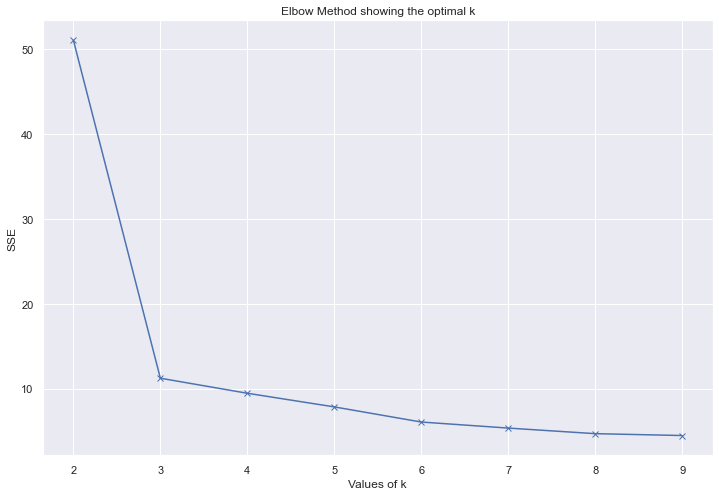

In [9]:
sse = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, init="kmeans++")
    labels_train, clusters_center, n_iterations = kmeans.fit(train_data)
    
    sse.append(kmeans.get_sse(by_cluster=False))

plt.figure(figsize=(12, 8))
plt.xlabel("Values of k")
plt.ylabel("SSE")
plt.title("Elbow Method showing the optimal k")
plt.plot(K, sse, "bx-")
plt.show()

### Silhouette analysis

For k = 2 The average silhouette_score is : 0.48710762726432905
For k = 3 The average silhouette_score is : 0.6270001561522708
For k = 4 The average silhouette_score is : 0.27297874665631394
For k = 5 The average silhouette_score is : 0.42985273129596113
For k = 6 The average silhouette_score is : 0.4452165487919453
For k = 7 The average silhouette_score is : 0.40538554270480637
For k = 8 The average silhouette_score is : 0.4043911801921442
For k = 9 The average silhouette_score is : 0.38055159046172365


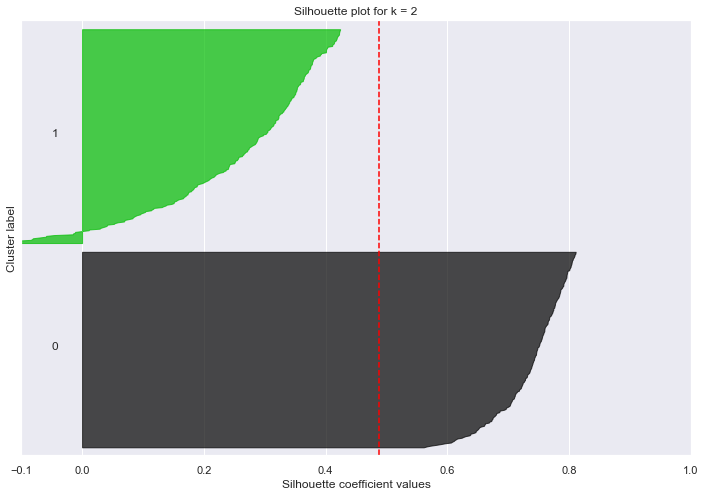

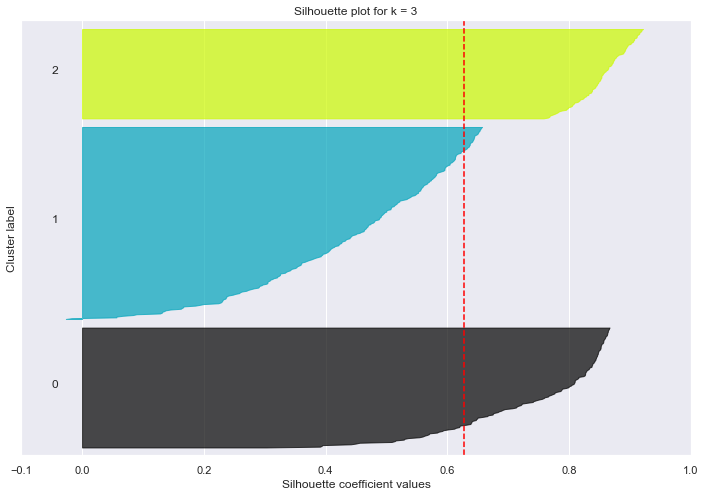

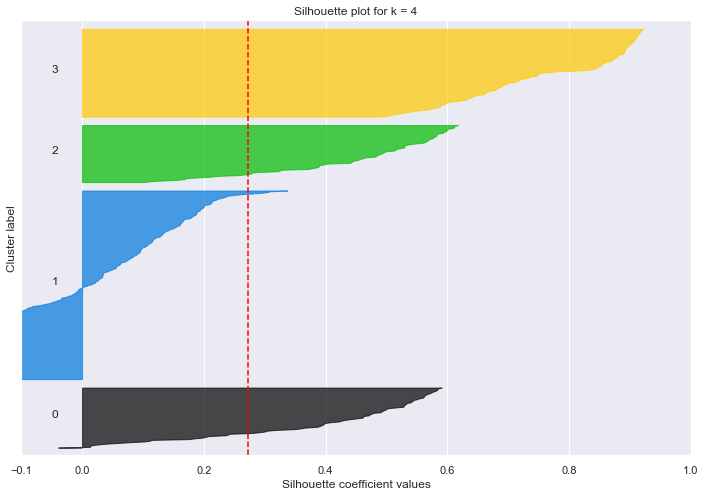

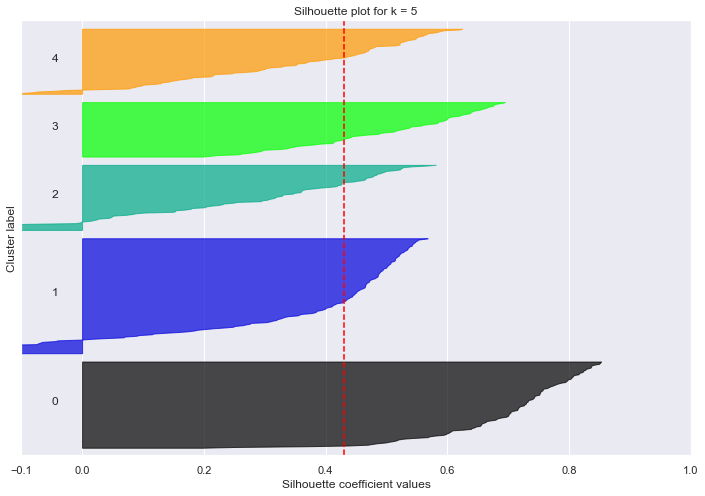

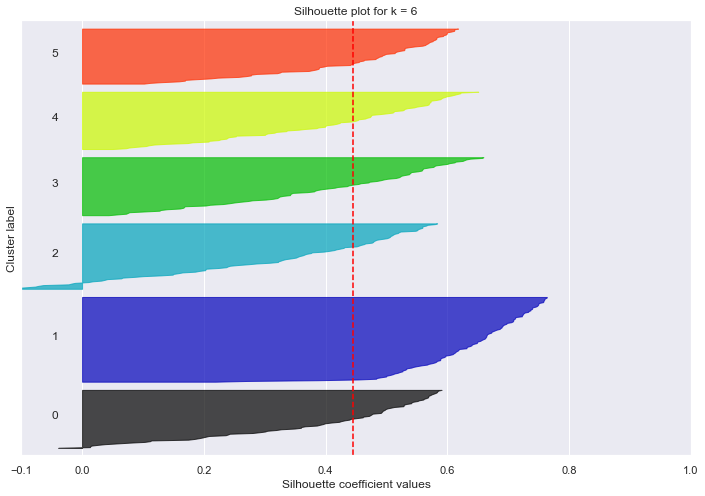

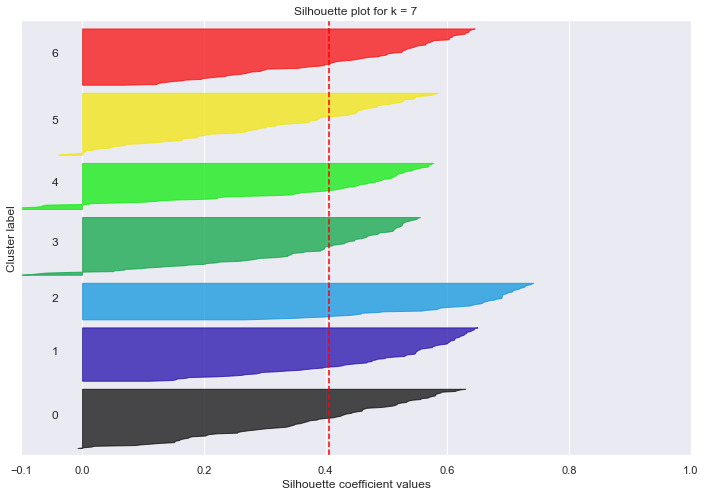

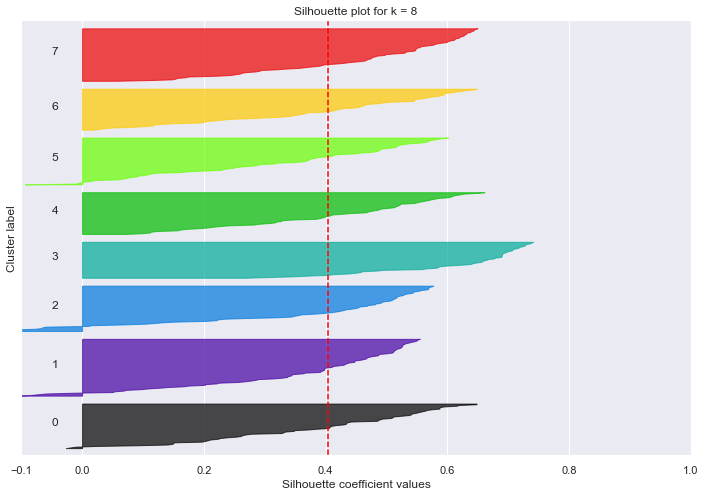

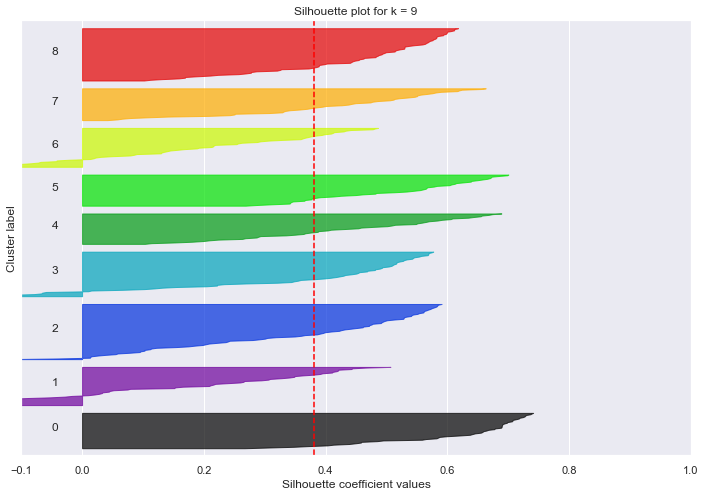

In [10]:
# Code adapted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, init="kmeans++")
    labels_train, clusters_center, n_iterations = kmeans.fit(train_data)

    silhouette_coeff, avg_silhouette_coeff = kmeans.get_silhouette_coefficient(train_data)
    
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(train_data) + (k + 1) * 10])
    
    print("For k =",  k,
          "The average silhouette_score is :", avg_silhouette_coeff)
    
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            silhouette_coeff[labels_train == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
        
    ax.set_title("Silhouette plot for k = {}".format(k))
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    ax.axvline(x=avg_silhouette_coeff, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    

plt.show()

## Training the algorithm

In [11]:
kmeans = KMeans(n_clusters=3, init="kmeans++")
labels_train, clusters_center, n_iterations = kmeans.fit(train_data)

print("Executed {} iterations".format(n_iterations))
print("Clusters center")
for i, cluster in enumerate(clusters_center):
    print("C{:}: {:}".format(i, cluster))

Executed 4 iterations
Clusters center
C0: [0.43205223 0.19200592]
C1: [0.88769433 0.74000959]
C2: [0.18074577 0.76860915]


<Figure size 864x576 with 0 Axes>

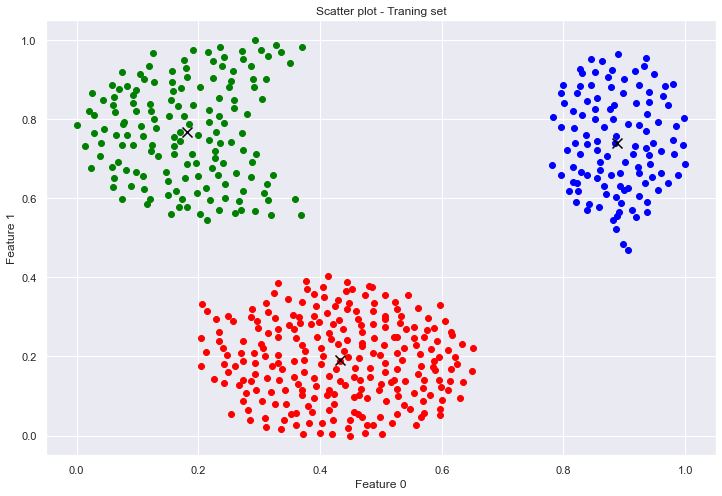

In [12]:
plt.figure(figsize=(12, 8))

plot_data_with_labels(train_data, clusters_center, labels_train, plot_title="Scatter plot - Traning set")

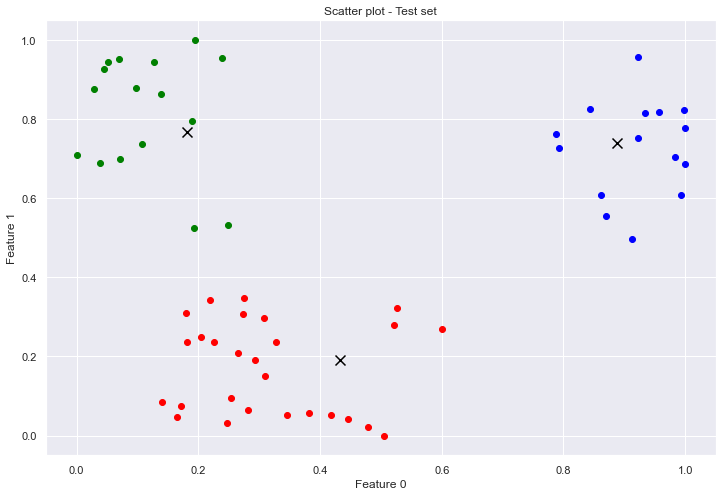

In [13]:
labels_test, _ = kmeans.predict(test_data)
plot_data_with_labels(test_data, clusters_center, labels_test, plot_title="Scatter plot - Test set")